## Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt

## Transform

In [2]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## Load Dataset

In [10]:
# Load datasets
train_data = datasets.ImageFolder(root=r"D:/code/Cnn EEg/database/train/", transform=transform)
test_data = datasets.ImageFolder(root=r"D:/code/Cnn EEg/database/test/", transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [8]:
train_loader.dataset

Dataset ImageFolder
    Number of datapoints: 588
    Root location: D:/code/Cnn EEg/database/train/
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               RandomResizedCrop(size=(32, 32), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

## Cnn


In [4]:
import torch.nn as nn
import torch.nn.functional as F

class SchizophreniaCNN(nn.Module):
    def __init__(self):
        super(SchizophreniaCNN, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.conv_layer2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.max_pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.conv_layer3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv_layer4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        self.max_pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.fc1 = nn.Linear(1600, 800)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(800, 400)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(400, 120)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(120, 60)
        self.relu4 = nn.ReLU()
        self.fc5 = nn.Linear(60, 2)

    
    # Progresses data across layers    
    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
        out = self.max_pool1(out)
        
        out = self.conv_layer3(out)
        out = self.conv_layer4(out)
        out = self.max_pool2(out)
                
        out = out.reshape(out.size(0), -1)
        
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.dropout1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.fc4(out)
        out = self.relu4(out)
        out = self.fc5(out)
        
        return out

## Load Params

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SchizophreniaCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

Epoch 1, Loss: 0.5559647414419386, Accuracy: 70.37037037037037
Acuracia das Imagens: 63.392857142857146 %
Epoch 2, Loss: 0.5567697087923685, Accuracy: 69.66490299823633
Acuracia das Imagens: 68.75 %
Epoch 3, Loss: 0.5680197013749017, Accuracy: 68.78306878306879
Acuracia das Imagens: 67.85714285714286 %
Epoch 4, Loss: 0.5574628876315223, Accuracy: 70.72310405643739
Acuracia das Imagens: 64.28571428571429 %
Epoch 5, Loss: 0.5694927275180817, Accuracy: 68.60670194003528
Acuracia das Imagens: 65.17857142857143 %
Epoch 6, Loss: 0.5566727850172255, Accuracy: 72.31040564373897
Acuracia das Imagens: 68.75 %
Epoch 7, Loss: 0.5611777040693495, Accuracy: 71.42857142857143
Acuracia das Imagens: 65.17857142857143 %
Epoch 8, Loss: 0.5538682275348239, Accuracy: 71.60493827160494
Acuracia das Imagens: 66.07142857142857 %
Epoch 9, Loss: 0.5664855142434438, Accuracy: 68.95943562610229
Acuracia das Imagens: 65.17857142857143 %
Epoch 10, Loss: 0.5628361039691501, Accuracy: 70.8994708994709
Acuracia das Im

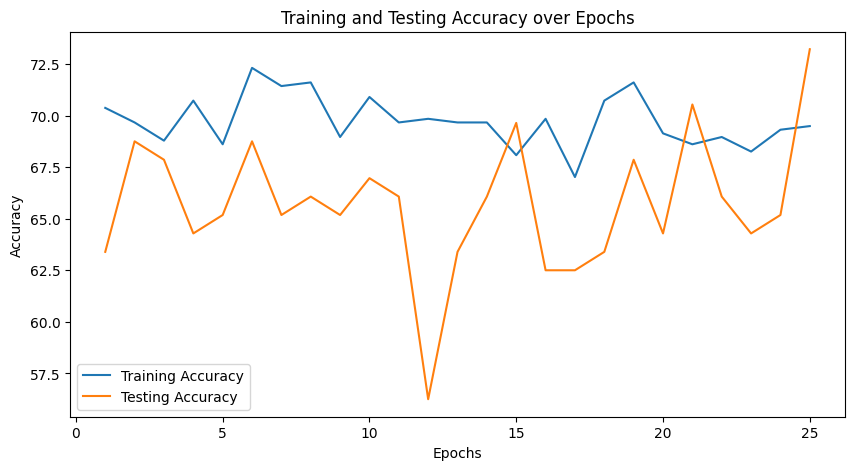

In [12]:
import matplotlib.pyplot as plt

# Initialize lists to store accuracies
train_accuracies = []
test_accuracies = []

# Training loop
epochs = 25
test_accu = 0
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    scheduler.step()
    train_accuracy = 100 * correct / total
    train_accuracies.append(train_accuracy)
    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}, Accuracy: {train_accuracy}")

    # Evaluation loop
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    test_accuracies.append(test_accuracy)
    print(f'Acuracia das Imagens: {test_accuracy} %')
    test_accu += test_accuracy

print(f"AQUI = {test_accu/epochs}")

# Plotting the accuracies
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs + 1), test_accuracies, label='Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy over Epochs')
plt.legend()
plt.show()

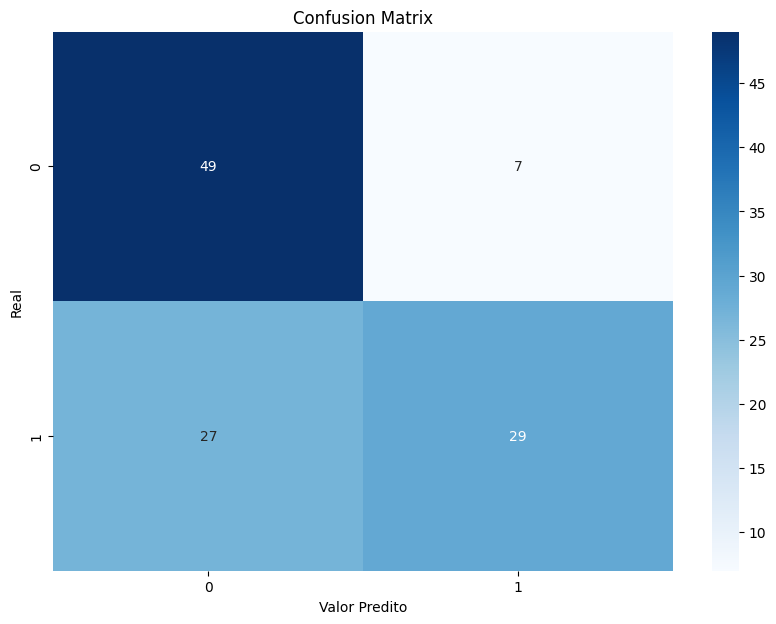

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Initialize lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Evaluation loop
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Create confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Valor Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

In [18]:
# Import the calculate_precision function
from sklearn.metrics import precision_score

def calculate_precision(model, test_loader, device):
    # Initialize lists to store true and predicted labels
    true_labels = []
    predicted_labels = []

    # Evaluation loop
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    # Calculate precision
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    return precision

# Call the function and print the precision
precision = calculate_precision(model, test_loader, device)
print(f'Precision: {precision}')

Precision: 0.7065331928345627


In [19]:
from sklearn.metrics import recall_score

def calculate_recall(model, test_loader, device):
    # Initialize lists to store true and predicted labels
    true_labels = []
    predicted_labels = []

    # Evaluation loop
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    # Calculate recall
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    return recall

# Call the function and print the recall
recall = calculate_recall(model, test_loader, device)
print(f'Recall: {recall}')

Recall: 0.6696428571428571


In [21]:
from sklearn.metrics import f1_score

def calculate_f1(model, test_loader, device):
    # Initialize lists to store true and predicted labels
    true_labels = []
    predicted_labels = []

    # Evaluation loop
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    # Calculate F1 score
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    return f1

# Call the function and print the F1 score
f1 = calculate_f1(model, test_loader, device)
print(f'F1 Score: {f1}')

F1 Score: 0.6618523051815586
